In [38]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import OneHotEncoder

# シグモイド関数の定義
def sigmoid(x):
    return 1./(1+np.exp(-x))

# シミュレーション用のクラス
class Simulator():
    def set_num_data(self, num_data):
        self.num_data = num_data

    def generate_linear_data(self):
        num_data = self.num_data
        # 説明変数x1, x2を生成し、介入と報酬を決定
        self.df = pd.DataFrame({
            "x1": np.random.normal(size=num_data),
            "x2": np.random.normal(size=num_data),
        }).assign(
            # 介入確率をシグモイド関数で決定し、3つの介入（0, 1, 2）をランダムに割り当て
            prob_t0 = lambda df: sigmoid(df.x1 + df.x2),
            prob_t1 = lambda df: (1-df.prob_t0)*sigmoid(df.x1**2 - df.x2),
            prob_t2 = lambda df: 1 - df.prob_t0 - df.prob_t1,
            t = lambda df: np.vectorize(lambda prob_t0, prob_t1, prob_t2: np.random.choice([0, 1, 2], p=[prob_t0, prob_t1, prob_t2]))(df["prob_t0"], df["prob_t1"], df["prob_t2"]),#np.random.choice([0, 1, 2], size=num_data, p=[0.3, 0.4, 0.3]),
            # 各介入に応じた報酬を設定
            reward = lambda df: df.x1 - df.x2 + df.t * 0.5
        )
        return self.df

    def generate_nonlinear_data(self):
        num_data = self.num_data
        self.df = pd.DataFrame({
            "x1": np.random.normal(size=num_data),
            "x2": np.random.normal(size=num_data),
        }).assign(
            prob_t0 = lambda df: sigmoid(np.sin(df.x1) - df.x2**2),
            prob_t1 = lambda df: (1-df.prob_t0)*sigmoid(df.x1**2 - df.x2),
            prob_t2 = lambda df: 1 - df.prob_t0 - df.prob_t1,
            t = lambda df: np.vectorize(lambda prob_t0, prob_t1, prob_t2: np.random.choice([0, 1, 2], p=[prob_t0, prob_t1, prob_t2]))(df["prob_t0"], df["prob_t1"], df["prob_t2"]),#np.random.choice([0, 1, 2], size=num_data, p=[0.3, 0.4, 0.3]),
            reward = lambda df: sigmoid(np.sin(df.x1) - df.x2**4) + df.t * 0.5
        )
        return self.df

    # IPS（Inverse Probability Weighting）法による因果効果の推定
    def IPS(self):
        df = self.df
        # 介入の確率をロジスティック回帰で推定（3クラス分類）
        model = LogisticRegression(multi_class='multinomial').fit(df[["x1", "x2"]], df["t"])
        # t_pred = model.predict_proba(df[["x1", "x2"]])
        epsilon = 1e-6  # 最小値を設定
        t_pred = np.clip(model.predict_proba(df[["x1", "x2"]]), epsilon, 1-epsilon)

        classes_ = model.classes_
        for i, c in enumerate(classes_):
            df[f"reward_treatment_{c}"] = df["reward"] * (df["t"] == c) / t_pred[:, i]

        # 3つの介入レベルの報酬の加重平均を計算
        df["reward_treatment"] = df["reward_treatment_0"] + df["reward_treatment_1"] + df["reward_treatment_2"]

        # # 真の因果効果を定義（効果: t=0 -> 0, t=1 -> 0.5, t=2 -> 1）
        # true_effect = df["t"] * 0.5

        # # 推定された因果効果の誤差を計算
        # return abs(df["reward_treatment"].mean() - true_effect.mean())
        return abs((df["reward_treatment_2"]-df["reward_treatment_0"]).mean()-1.)

    # DM（Direct Method）法による因果効果の推定
    def DM(self):
        df = self.df
        t_encoded = pd.get_dummies(df["t"]).values

        # 線形回帰モデルを使って報酬を予測
        model = LinearRegression().fit(np.hstack([df[["x1", "x2"]], t_encoded]), df["reward"])

        # 各介入レベルに対して、x1, x2と介入ダミー変数を含むデータを生成
        rewards = []
        for i in range(3):
            t_encoded_i = np.zeros_like(t_encoded)
            t_encoded_i[:, i] = 1
            X_new = np.hstack([df[["x1", "x2"]], t_encoded_i])
            rewards.append(model.predict(X_new))
        
        # 各介入レベルごとの報酬を合計して平均する
        df["reward_treatment_0"] = rewards[0]
        df["reward_treatment_1"] = rewards[1]
        df["reward_treatment_2"] = rewards[2]

        # # 真の因果効果を定義（効果: t=0 -> 0, t=1 -> 0.5, t=2 -> 1）
        # true_effect = df["t"] * 0.5

        # # 推定された因果効果の誤差を計算
        return abs((df["reward_treatment_2"]-df["reward_treatment_0"]).mean()-1.)


    def sim_linear(self):
        ress = []
        for num_data in [100, 200, 400, 800, 1600, 6400, 12800]:
            res = {"num_data": num_data}
            self.set_num_data(num_data)
            ips = []
            dm = []
            for _ in range(100):
                self.generate_linear_data()
                ips.append(self.IPS())
                dm.append(self.DM())
            res["IPS"] = np.mean(ips)
            res["DM"] = np.mean(dm)
            ress.append(res)
        return pd.DataFrame(ress).set_index("num_data")

    def sim_nonlinear(self):
        ress = []
        for num_data in [100, 200, 400, 800, 1600, 12800]:
            res = {"num_data": num_data}
            self.set_num_data(num_data)
            ips = []
            dm = []
            for _ in range(100):
                self.generate_nonlinear_data()
                ips.append(self.IPS())
                dm.append(self.DM())
            res["IPS"] = np.mean(ips)
            res["DM"] = np.mean(dm)
            ress.append(res)
        return pd.DataFrame(ress).set_index("num_data")


In [39]:
simulator = Simulator()

# 線形モデルを線形モデルでFitingする場合
- DMの精度はIPSよりもよい

In [40]:
simulator.sim_linear().plot(ylabel="error")

# 非線形モデルを線形モデルでFitingする場合
- IPSの精度がDMを上回る

<Axes: xlabel='num_data', ylabel='error'>

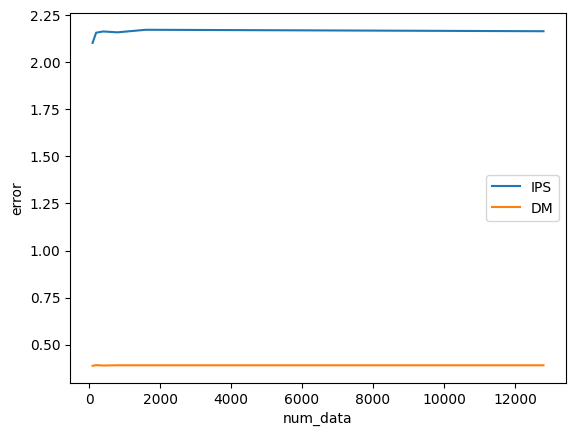

In [28]:
simulator.sim_nonlinear().plot(ylabel="error")